```
Author: Yagnik Poshiya
GitHub: @yagnikposhiya
U & PU. Patel Department of Computer Engineering,
Chandubhai S. Patel Institute of Science and Technology,
Charotar University of Science and Technology,
Changa-388421, Anand, Gujarat, India.
```

## Load Libraries

In [1]:
import tensorflow
import matplotlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from keras import Model, Input
from keras.optimizers import Adam
from keras.metrics import CategoricalAccuracy
from keras.utils import plot_model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.utils import load_img
from keras.utils import img_to_array
from keras.models import Model
import matplotlib.pyplot as plt
from numpy import expand_dims

2023-03-16 12:04:19.435795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 12:04:19.907454: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-16 12:04:19.946419: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-16 12:04:19.946465: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

## Load Dataset

In [2]:
datagen_train = ImageDataGenerator(samplewise_center=True,
                                   rescale=1./255,
                                   fill_mode='nearest',
                                   brightness_range=[0.4,1.5],
                                   rotation_range=10,
                                   zoom_range=0.1,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True)
datagen_valid = ImageDataGenerator(samplewise_center=True)

train_set = datagen_train.flow_from_directory('/path_to_train_directory/train/',
                                              target_size=(224,224),
                                              color_mode="rgb",
                                              class_mode="categorical",
                                              batch_size=32,
                                              save_to_dir='/path_to_augmented_directory/_augmented_/',
                                              save_prefix='aug',
                                              save_format='png')
validation_set = datagen_valid.flow_from_directory('/path_to_validation_directory/validation/',
                                                   target_size=(224,224),
                                                   color_mode="rgb",
                                                   class_mode="categorical",
                                                   batch_size=32)

print("Classes and their Indices: \n{a}".format(a=train_set.class_indices))

Found 120 images belonging to 6 classes.
Found 60 images belonging to 6 classes.
Classes and their Indices: 
{'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}


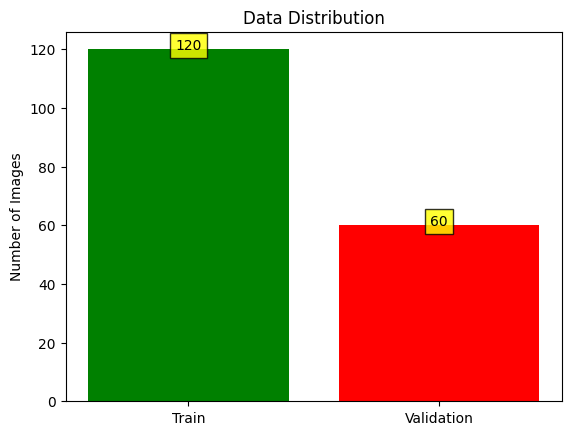

In [3]:
def showDataDistribution():
    plt.bar(['Train','Validation'],
            [train_set.samples, validation_set.samples],
            align='center',
            color=['green','red'])
    plt.ylabel('Number of Images')
    plt.title('Data Distribution')
    for iteration in range(2):
        x = ['Train','Validation']
        y = [train_set.samples,validation_set.samples]
        plt.text(x=x[iteration],
                 y=y[iteration],
                 s=str(y[iteration]),
                 ha='center',
                 bbox=dict(facecolor='yellow',alpha=0.8))
    plt.show()

showDataDistribution()

## Load Pre-trained Model

In [4]:
base_model = keras.applications.VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False)

2023-03-16 12:04:43.487391: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-16 12:04:43.487444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning): /proc/driver/nvidia/version does not exist
2023-03-16 12:04:43.487904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Featuremap Visualization

In [6]:
for i in range(len(base_model.layers)):
    layer = base_model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

1 block1_conv1 (None, 224, 224, 64)
2 block1_conv2 (None, 224, 224, 64)
4 block2_conv1 (None, 112, 112, 128)
5 block2_conv2 (None, 112, 112, 128)
7 block3_conv1 (None, 56, 56, 256)
8 block3_conv2 (None, 56, 56, 256)
9 block3_conv3 (None, 56, 56, 256)
11 block4_conv1 (None, 28, 28, 512)
12 block4_conv2 (None, 28, 28, 512)
13 block4_conv3 (None, 28, 28, 512)
15 block5_conv1 (None, 14, 14, 512)
16 block5_conv2 (None, 14, 14, 512)
17 block5_conv3 (None, 14, 14, 512)


1/1 [==============================] - 1s 524ms/step


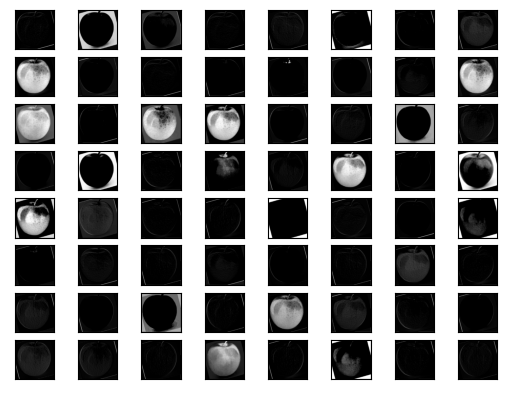

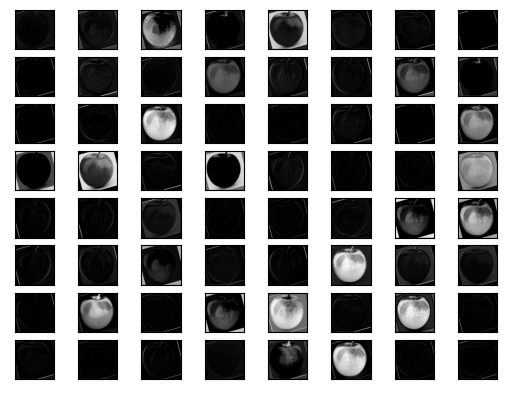

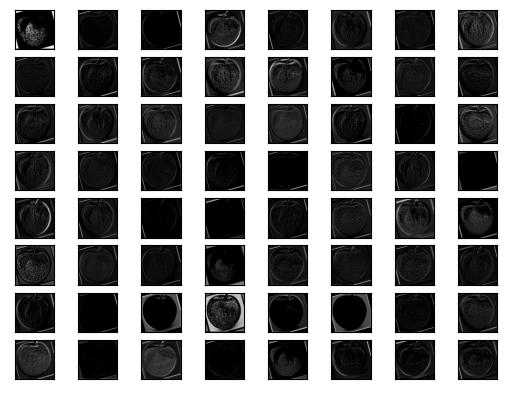

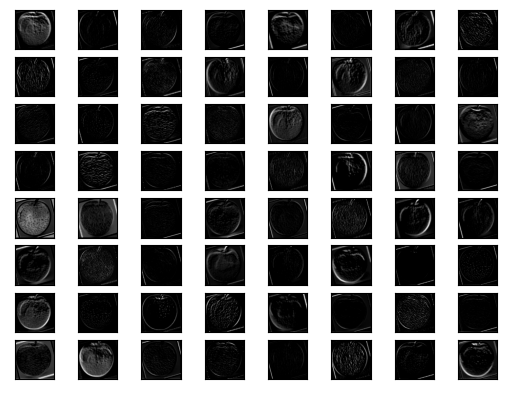

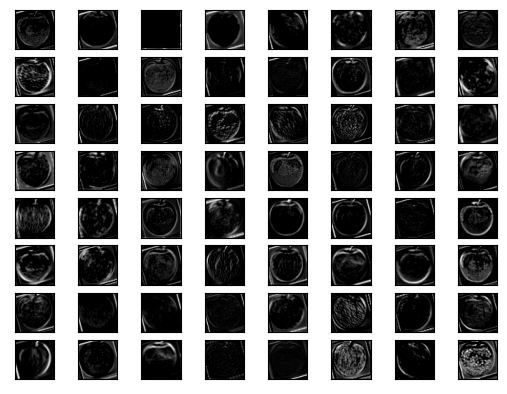

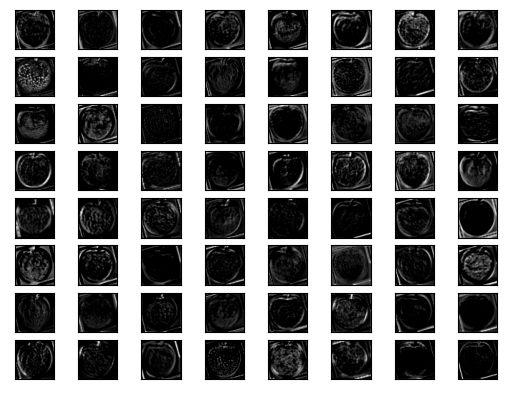

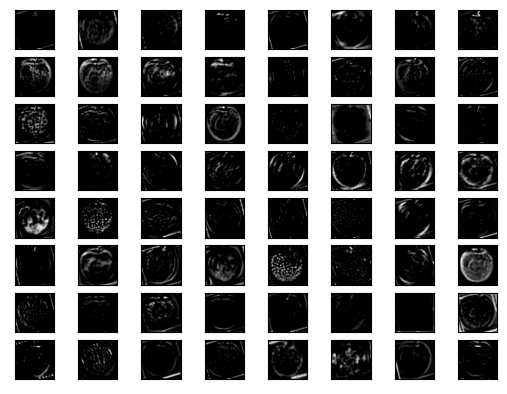

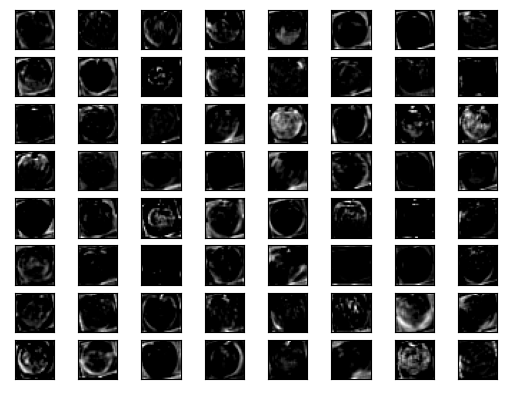

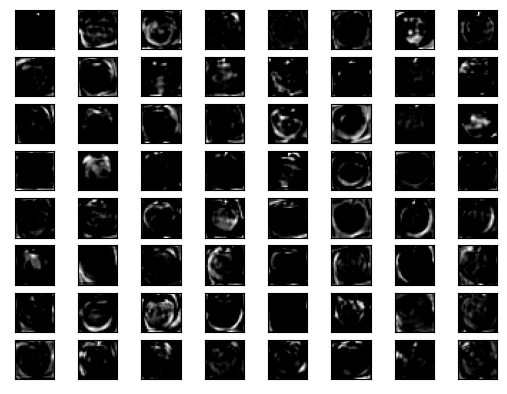

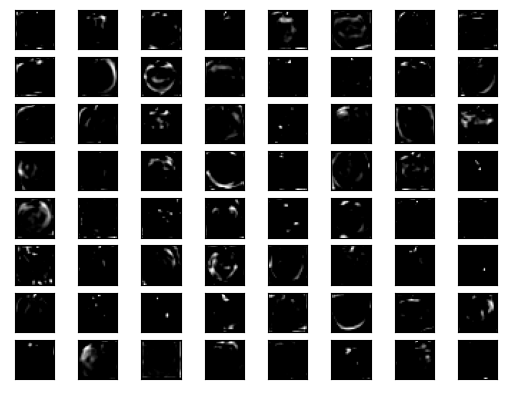

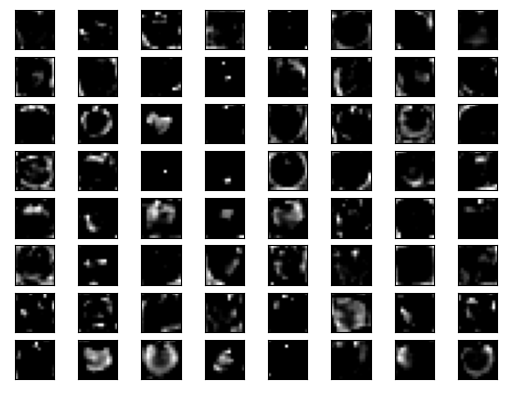

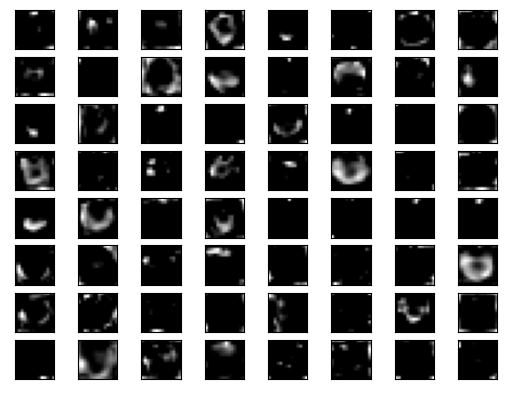

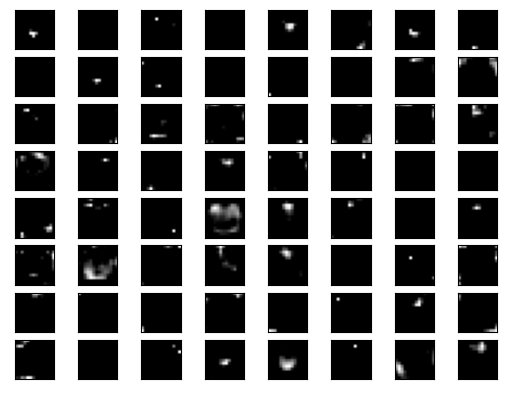

In [7]:
ixs = [1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17]

outputs = [base_model.layers[i].output for i in ixs]
feature_model = Model(inputs=base_model.inputs, outputs=outputs)

img = load_img('/path_to_fmapimages_directory/_fmapimages_/apple.png', target_size=(224, 224))

img = img_to_array(img)
img = expand_dims(img, axis=0)

img = preprocess_input(img)
feature_maps = feature_model.predict(img)

square = 8
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
             ax = plt.subplot(square, square, ix)
             ax.set_xticks([])
             ax.set_yticks([])
             plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
             ix += 1
    plt.show()

## Add Layers to Model

In [8]:
base_model.trainable=False

In [9]:
input_layer = Input(shape=(224,224,3))
output_base_model = base_model(input_layer, training=False)
averagePooling = GlobalAveragePooling2D()(output_base_model)
dense1 = Dense(64, activation='relu')(averagePooling)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = Dense(16, activation='relu')(dense2)
output_layer = Dense(6, activation='softmax')(dense3)

model = Model(input_layer,output_layer)

model.compile(loss='categorical_crossentropy',
              metrics=CategoricalAccuracy(name='accuracy'))

In [10]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                           

## Plot the Architecture

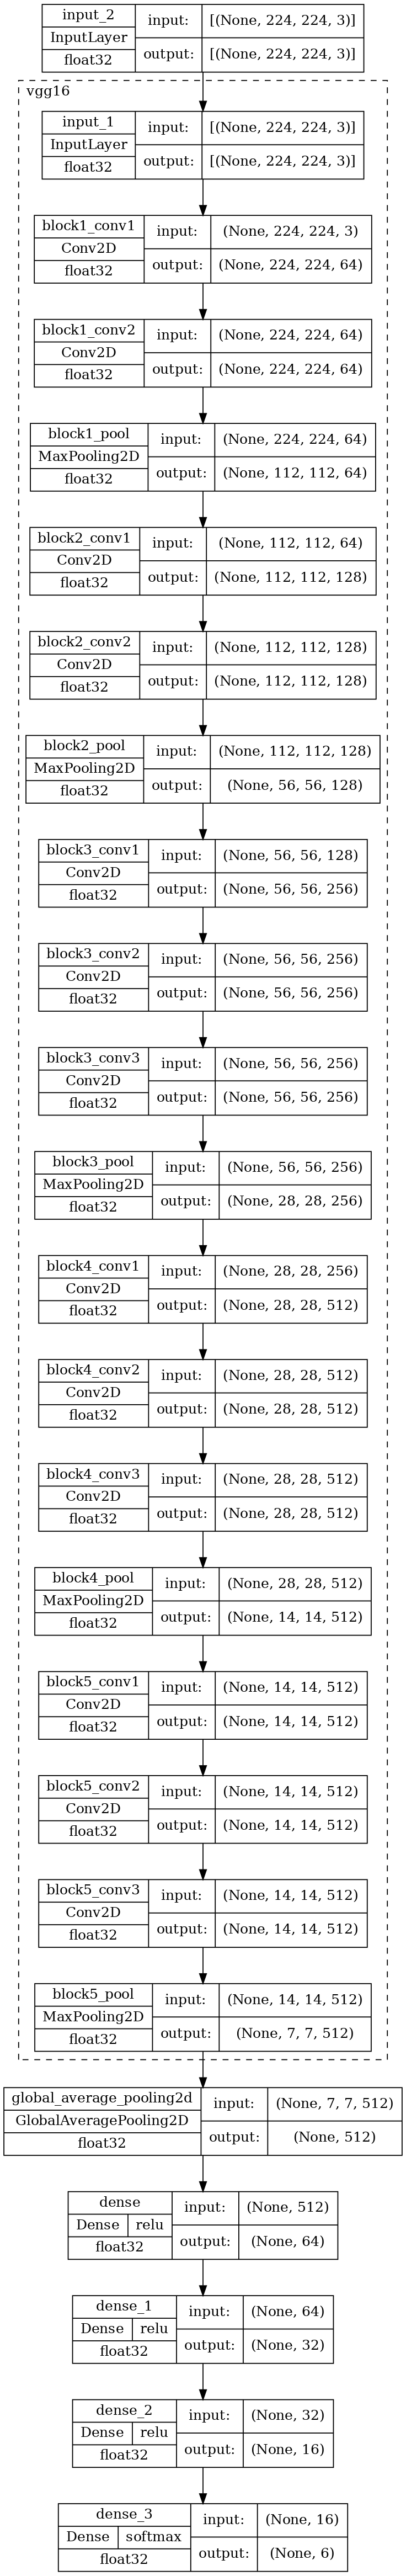

In [11]:
plot_model(model,
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=True,
           show_layer_activations=True,
           dpi=128)

## Plot the 3D Architecture

In [13]:
import visualkeras
from PIL import ImageFont
from collections import defaultdict

font = ImageFont.truetype("/path_to_font_file/arial.ttf", 32)
color_map = defaultdict(dict)
color_map[Conv2D]['fill'] = 'orange'
color_map[Dense]['fill'] = 'green'

visualkeras.layered_view(model,
                         legend=True,
                         spacing=25,
                         color_map=color_map,
                         font=font,
                         to_file='output_2.png').show()

## Train the Model

In [14]:
history = model.fit(train_set,
                    validation_data=validation_set,
                    steps_per_epoch=train_set.samples/train_set.batch_size,
                    validation_steps=validation_set.samples/validation_set.batch_size,
                    epochs=10)

Epoch 1/10
3/3 [==============================] - 41s 12s/step - loss: 1.8187 - accuracy: 0.1833 - val_loss: 5.0147 - val_accuracy: 0.1500
Epoch 2/10
3/3 [==============================] - 40s 12s/step - loss: 1.7647 - accuracy: 0.2333 - val_loss: 4.5562 - val_accuracy: 0.1667
Epoch 3/10
3/3 [==============================] - 37s 11s/step - loss: 1.7062 - accuracy: 0.3333 - val_loss: 6.3105 - val_accuracy: 0.1833
Epoch 4/10
3/3 [==============================] - 36s 10s/step - loss: 1.6806 - accuracy: 0.3750 - val_loss: 4.8886 - val_accuracy: 0.2167
Epoch 5/10
3/3 [==============================] - 37s 11s/step - loss: 1.6627 - accuracy: 0.4167 - val_loss: 4.8207 - val_accuracy: 0.2333
Epoch 6/10
3/3 [==============================] - 46s 14s/step - loss: 1.5931 - accuracy: 0.4083 - val_loss: 4.8269 - val_accuracy: 0.2500
Epoch 7/10
3/3 [==============================] - 40s 11s/step - loss: 1.5613 - accuracy: 0.4250 - val_loss: 5.3021 - val_accuracy: 0.3167
Epoch 8/10
3/3 [===========

In [15]:
model.save('/path_to_model_directory/_model_/fruit_classification_with_pretrained.h5')

## Unfreeze the Model for Fine Tuning

In [16]:
base_model.trainable=True

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=CategoricalAccuracy(name='accuracy'))

history = model.fit(train_set,
                    validation_data=validation_set,
                    steps_per_epoch=train_set.samples/train_set.batch_size,
                    validation_steps=validation_set.samples/validation_set.batch_size,
                    epochs=10)

Epoch 1/10
3/3 [==============================] - 95s 27s/step - loss: 2.0410 - accuracy: 0.2917 - val_loss: 9.1286 - val_accuracy: 0.1667
Epoch 2/10
3/3 [==============================] - 78s 21s/step - loss: 1.6173 - accuracy: 0.2750 - val_loss: 37.6902 - val_accuracy: 0.2833
Epoch 3/10
3/3 [==============================] - 95s 29s/step - loss: 1.4134 - accuracy: 0.4667 - val_loss: 71.6686 - val_accuracy: 0.3167
Epoch 4/10
3/3 [==============================] - 98s 27s/step - loss: 1.1426 - accuracy: 0.4750 - val_loss: 77.0143 - val_accuracy: 0.4000
Epoch 5/10
3/3 [==============================] - 100s 27s/step - loss: 1.3926 - accuracy: 0.5000 - val_loss: 71.1833 - val_accuracy: 0.2833
Epoch 6/10
3/3 [==============================] - 92s 27s/step - loss: 1.4859 - accuracy: 0.3583 - val_loss: 75.1314 - val_accuracy: 0.2667
Epoch 7/10
3/3 [==============================] - 96s 27s/step - loss: 1.3445 - accuracy: 0.4417 - val_loss: 35.0612 - val_accuracy: 0.2500
Epoch 8/10
3/3 [====

In [17]:
model.save('/path_to_model_directory/_model_/fruit_classification_with_pretrained_full_trained.h5')

## Plot the Learning Curves

In [18]:
values = history.history

training_accuracy=values['accuracy']
validation_accuracy=values['val_accuracy']

training_loss=values['loss']
validation_loss=values['val_loss']

epoch = range(len(training_accuracy))

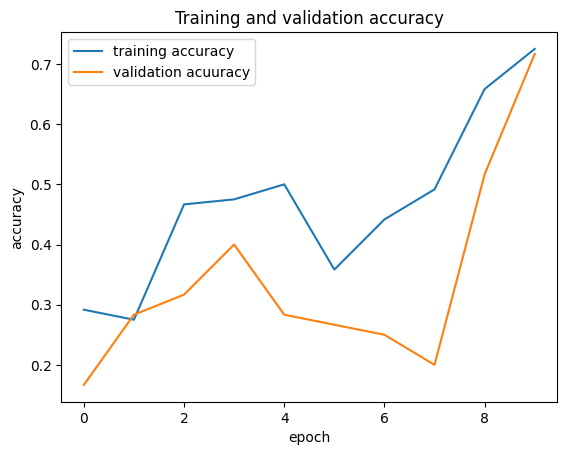

In [19]:
plt.figure()
plt.plot(epoch,
         training_accuracy,
         label='training accuracy')
plt.plot(epoch,
         validation_accuracy,
         label='validation acuuracy')
plt.title('Training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.savefig('/path_to_figures_directory/_figures_/training-validation_accuracy_full_trained.png',
            format='png',
            dpi=400)

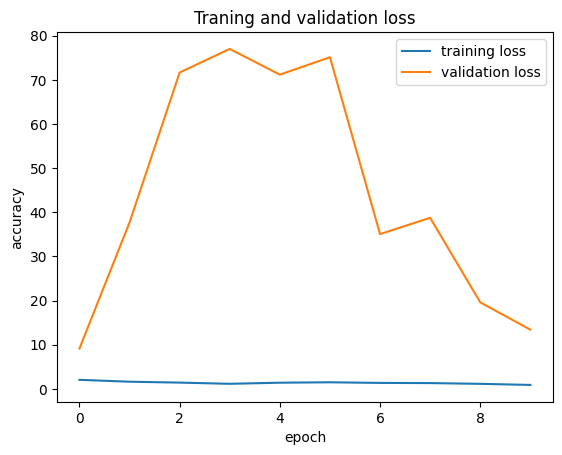

In [20]:
plt.figure()
plt.plot(epoch,
         training_loss,
         label='training loss')
plt.plot(epoch,
         validation_loss,
         label='validation loss')
plt.title('Traning and validation loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

plt.savefig('/path_to_figures_directory/_figures_/training-validation_loss_full_trained.png',
            format='png',
            dpi=400)

## Test the Model

In [23]:
IMG = cv2.imread('/path_to_test_directory/test/fb2.png')
RESIZE_IMG = cv2.resize(IMG, (224,224))
PROCESSED_IMG = np.array(RESIZE_IMG).reshape(-1,224,224,3)

In [24]:
prediction_prob = model.predict(PROCESSED_IMG)
print("Classwise probability: {a}".format(a=prediction_prob))
print("Classes: {b}".format(b=train_set.class_indices))

1/1 [==============================] - 0s 287ms/step
Classwise probability: [[0. 1. 0. 0. 0. 0.]]
Classes: {'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}
